In [73]:
import numpy as np
import time
import os
import cv2
import sys

# Now cluster the data

%pylab inline
import os
import keras
import cv2
import time
import numpy as np
import pandas as pd
import keras.backend as K
import tensorflow as tf

import sklearn.metrics as metrics

from keras import callbacks
from keras.models import Model
from keras.optimizers import SGD
from keras.initializers import VarianceScaling
from keras.engine.topology import Layer, InputSpec
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Conv2DTranspose, Flatten
from keras.layers import Reshape, UpSampling2D, BatchNormalization, Cropping2D, Concatenate
from keras.callbacks import ModelCheckpoint, EarlyStopping


os.getcwd()
home_dir = os.path.abspath('../../')
data_dir = os.path.join(home_dir, 'data', 'ua_detrac',  'DETRAC-Images')
data_dir

home_dir

filter_path = os.path.join(home_dir, 'filters')
loader_path = os.path.join(home_dir, 'loaders')

sys.path.append(home_dir)
sys.path.append(loader_path)
sys.path.append(filter_path)

Populating the interactive namespace from numpy and matplotlib


/nethome/jbang36/anaconda3/envs/eva_37/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random', 'gray', 'load']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [5]:
import sys
sys.executable

'/nethome/jbang36/anaconda3/envs/eva_37/bin/python'

In [7]:
# Load the data
from loaders.load import Load

start_time = time.time()
load = Load()

eva_dir = home_dir
image_dir = os.path.join(eva_dir, "data", "ua_detrac", "small-data")
anno_dir = os.path.join(eva_dir, "data", "ua_detrac", "small-annotations")

X, length_per_mvi = load.load_images(image_dir, grayscale = False)
Y_dict = load.load_XML(anno_dir, X, length_per_mvi)

print("Total time to load small data is", time.time() - start_time, "seconds")

  0%|          | 3/10421 [00:00<06:49, 25.42it/s]

image directory is  /home/jbang36/eva/data/ua_detrac/small-data
Length of file_names: 10421


100%|██████████| 10421/10421 [02:01<00:00, 85.50it/s] 
1it [00:00,  2.63it/s]

MVI_20011.xml
mvi length: 664
car_labels length: 664


2it [00:00,  2.71it/s]

MVI_20012.xml
mvi length: 1600
car_labels length: 1600
MVI_20032.xml
mvi length: 2037
car_labels length: 2037


4it [00:01,  3.33it/s]

MVI_20033.xml
mvi length: 2821
car_labels length: 2821


5it [00:01,  3.07it/s]

MVI_20034.xml
mvi length: 3621
car_labels length: 3621


6it [00:01,  2.77it/s]

MVI_20035.xml
mvi length: 4421
car_labels length: 4421


7it [00:02,  2.75it/s]

MVI_20051.xml
mvi length: 5327
car_labels length: 5327


8it [00:02,  2.70it/s]

MVI_20052.xml
mvi length: 6021
car_labels length: 6021


9it [00:02,  2.89it/s]

MVI_20061.xml
mvi length: 6821
car_labels length: 6821


10it [00:03,  3.23it/s]

MVI_20062.xml
mvi length: 7621
car_labels length: 7621


11it [00:03,  3.29it/s]

MVI_20063.xml
mvi length: 8421
car_labels length: 8421


12it [00:03,  2.69it/s]

MVI_20064.xml
mvi length: 9221
car_labels length: 9221


13it [00:04,  2.07it/s]

MVI_20065.xml
mvi length: 10421
car_labels length: 10421
Total time to load small data is 126.61764669418335 seconds


In [52]:
# I am wondering if we downsample and normalize the input early and just apply those images as training, it will affect performance in any way..
# so after running _split_train_test here is the code we should run

# Divide the data into train, test

def _split_train_test(X,Y_dict):
    n_samples, _, _, _= X.shape
    train_index_end = int(len(X) * 0.8)

    X_train = X[:train_index_end]
    X_test = X[train_index_end:]

    Y_dict_train = {}
    Y_dict_test = {}
    for column in Y_dict:
        Y_dict_train[column] = Y_dict[column][:train_index_end]
        Y_dict_test[column] = Y_dict[column][train_index_end:]

    return X_train, X_test, Y_dict_train, Y_dict_test

X_train, X_test, Y_train_dict, Y_test_dict = _split_train_test(X, Y_dict)


X_train_norm = np.copy(X_train)
X_test_norm = np.copy(X_test)

def _format_image(X, sampling_rate=12):
    print("before:", X.shape)
    reduction_rate = sampling_rate
    # need to down shape them so that the kernels can train faster
    # image should be num_samples, height, width, channel
    downsampled_images = X[:, ::reduction_rate, ::reduction_rate, :]
    downsampled_images = downsampled_images.astype(np.float32)
    print("After change, shape of image is", downsampled_images.shape)
    downsampled_images /= 255.0
    return downsampled_images

X_train_norm = _format_image(X_train_norm)
X_test_norm = _format_image(X_test_norm)

before: (8336, 540, 960, 3)
After change, shape of image is (8336, 45, 80, 3)
before: (2085, 540, 960, 3)
After change, shape of image is (2085, 45, 80, 3)


(540, 960, 3)
(540, 960, 3)
(540, 960, 3)


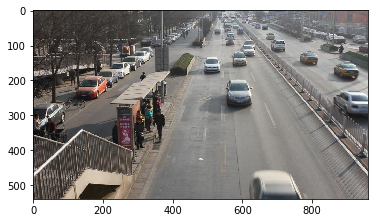

In [9]:
import matplotlib.pyplot as plt
import random
image_index = random.randint(0,100) # You may select anything up to 60,000
print(X_train[image_index].shape)

example = X_train[image_index]
width, height, channels = example.shape
example = np.squeeze(example)
print(np.squeeze(example).shape)
print(example.shape)

plt.imshow(example)

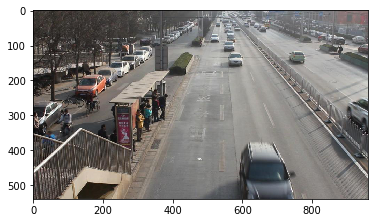

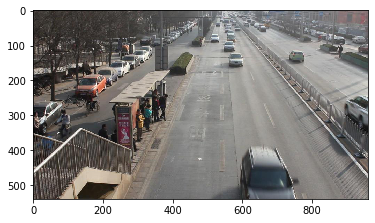

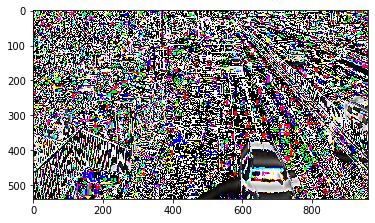

In [10]:
#  I want to try background subtraction

image1 = np.squeeze(X_train[0])
image2 = np.squeeze(X_train[1])
image_sub = image2 - image1
width,height,channels = image_sub.shape


plt.imshow(image1)
plt.show()
plt.imshow(image2)
plt.show()

plt.imshow(image_sub)
plt.show()


In [28]:
print(image_sub.shape)

image_sub2 = np.copy(image_sub)
image_sub3 = image_sub2.reshape((1, -1))
# draw a histogram of where the cutoff could be




(540, 960, 3)


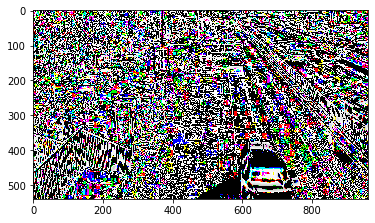

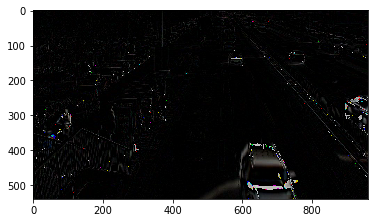

In [33]:
image_sub2 = np.copy(image_sub)
image_sub2[image_sub2 > 200] = 0
image_subsub = image_sub - image_sub2

plt.imshow(image_subsub)
plt.show()
plt.imshow(image_sub2)
plt.show()

(540, 960, 3)
(540, 960)


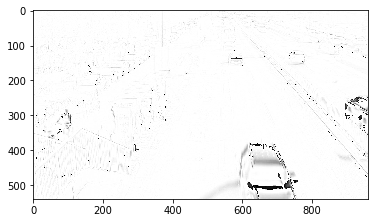

total time is 0.011463165283203125 seconds
(100, 1, 2)
[[734. 129.]]
734.0 129.0


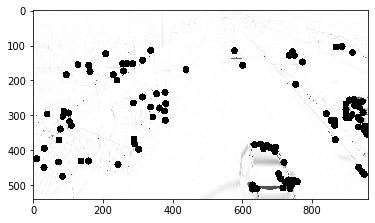

(<matplotlib.image.AxesImage at 0x7f12953fccc0>, None)

In [48]:
print(image_sub2.shape)

#convert the image to gray
gray = cv2.cvtColor(image_sub2,cv2.COLOR_RGB2GRAY)
print(gray.shape)
plt.imshow(gray, cmap = "Greys")
plt.show()

import time

s = time.time()
vocab_corners = cv2.goodFeaturesToTrack(np.float32(gray),100,0.1,10)
print("total time is", time.time() - s, "seconds")

print(vocab_corners.shape)
print(vocab_corners[0])
x,y = vocab_corners[0].ravel()
print(x,y)

for i in vocab_corners:
    x,y = i.ravel()
    
    cv2.circle(gray,(x,y),10,255,-1)
plt.imshow(gray, cmap='Greys'),plt.show()


(540, 960)


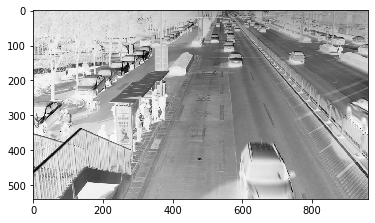

total time is 0.010266780853271484 seconds
(100, 1, 2)
[[258. 174.]]
258.0 174.0


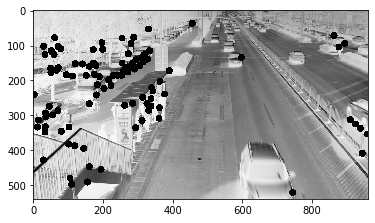

(<matplotlib.image.AxesImage at 0x7f12953ee278>, None)

In [49]:
#convert the image to gray
gray = cv2.cvtColor(image1,cv2.COLOR_RGB2GRAY)
print(gray.shape)
plt.imshow(gray, cmap = "Greys")
plt.show()

import time

s = time.time()
vocab_corners = cv2.goodFeaturesToTrack(np.float32(gray),100,0.1,10)
print("total time is", time.time() - s, "seconds")

print(vocab_corners.shape)
print(vocab_corners[0])
x,y = vocab_corners[0].ravel()
print(x,y)

for i in vocab_corners:
    x,y = i.ravel()
    
    cv2.circle(gray,(x,y),10,255,-1)
plt.imshow(gray, cmap='Greys'),plt.show()




In [ ]:
# code to generate patches


# Get patches from interest points
patches = [np.squeeze(train_x[i])[corner[1]-8:corner[1]+8,corner[0]-8:corner[0]+8, np.newaxis] for i in range(len(train_x)) for corner in vocab_corners[i]]

patches_filtered = []
# Remove corner patches
for i in range(len(patches)):
    if patches[i].shape == (16, 16, 1):
        patches_filtered.append(patches[i])


patches = np.array(patches_filtered)
plt.imshow(np.squeeze(patches[0]), cmap='Greys'),plt.show()

# Normalize patches
patches /= 255.0

In [66]:
a = np.array([1,2,3,4,5,-1,-2,-3])
print(np.absolute(a))

[1 2 3 4 5 1 2 3]


In [71]:
def show_points(image1, image2, count = 100, normalized = False):
    #we will assume the image has 3 channels
    if not normalized:
        image1 *= 255
        image1 = image1.astype(np.uint8)
        image2 *= 255
        image2 = image2.astype(np.uint8)
        
    image = image1 - image2
    image[image > 100] = 0
    image[image < 0 ] = 0
    
    plt.imshow(image)
    plt.show()
    
    print("image shape is", image.shape)
    

    #convert the image to gray
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

    vocab_corners = cv2.goodFeaturesToTrack(np.float32(gray),count,0.1,10)
    x,y = vocab_corners[0].ravel()
    for i in vocab_corners:
        x,y = i.ravel()
        cv2.circle(gray,(x,y),3,255,-1)
        cv2.circle(image1, (x,y),1, 255, -1)
    plt.imshow(gray, cmap='Greys')
    plt.show()
    plt.imshow(image1)
    plt.show()
    return

(8336, 45, 80, 3)
(2085, 45, 80, 3)
0.3019608


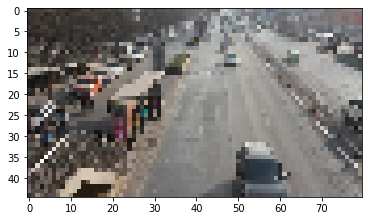

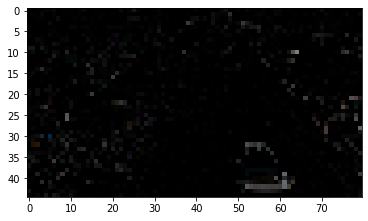

image shape is (45, 80, 3)


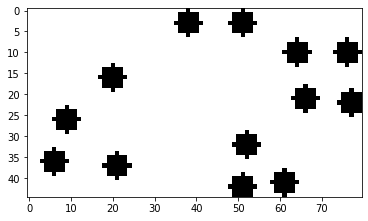

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


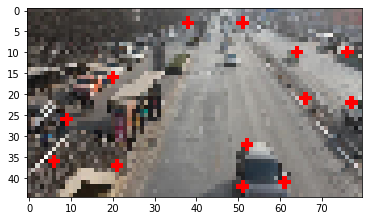

In [72]:
print(X_train_norm.shape)
print(X_test_norm.shape)

print(X_train_norm[0][0][0][0])


test_image1 = np.copy(X_train_norm[0])
test_image2 = np.copy(X_train_norm[1])


plt.imshow(test_image)
plt.show()

show_points(test_image1, test_image2, normalized = True)


## Now for network creation

In [55]:
keras.backend.clear_session()
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [ ]:
def batch_wrapper(x):
    return BatchNormalization(axis=1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', 
                                moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                beta_constraint=None, gamma_constraint=None)(x)
    
    

In [ ]:
def U_net(input_layer_needed, x = None, width = 0, height = 0, output_channels = 3):
    
    if input_layer_needed:
        x = Input(shape=(width, height, 3))
    if input_layer_needed == False and x == None:
        print("Input layer is needed or X is needed... returning")
        return None
    
    # Encoder
    x1 = Conv2D(16,(3,3),
               activation='relu',
               padding='same')(x)
    x1 = batch_wrapper(x1)
    x1 = Conv2D(16,(3,3),
               activation='relu',
               padding='same')(x1)
    x1 = batch_wrapper(x1)
    x2 = MaxPooling2D((2,2),
                     padding='same')(x1) 

    x2 = Conv2D(32,(3,3),
               activation='relu',
               padding='same')(x2)
    x2 = batch_wrapper(x2)
    x2 = Conv2D(32,(3,3),
               activation='relu',
               padding='same')(x2)
    x2 = batch_wrapper(x2)
    x3 = MaxPooling2D((2,2),
                     padding='same')(x2) 

    x3 = Conv2D(64,(3,3),
               activation='relu',
               padding='same')(x3)
    x3 = batch_wrapper(x3)
    x3 = Conv2D(64,(3,3),
               activation='relu',
               padding='same')(x3)
    x3 = batch_wrapper(x3)
    x4 = MaxPooling2D((2,2),
                     padding='same')(x3) 

    x4 = Conv2D(128,(3,3),
               activation='relu',
               padding='same')(x4)
    x4 = batch_wrapper(x4)
    x4 = Conv2D(128,(3,3),
               activation='relu',
               padding='same')(x4)
    x4 = batch_wrapper(x4)

    x5 = UpSampling2D((2, 2))(x4)
    x5 = Concatenate(axis=-1)([x3, x5]) #channels should be 296
    x5 = Conv2D(128,(3,3),
               activation='relu',
               padding='same')(x5)
    x5 = batch_wrapper(x5)
    x5 = Conv2D(128,(3,3),
               activation='relu',
               padding='same')(x5)
    x5 = batch_wrapper(x5)

    x6 = UpSampling2D((2, 2))(x5)
    x6 = Concatenate(axis=-1)([x2, x6]) #channels should be 296
    x6 = Conv2D(64,(3,3),
               activation='relu',
               padding='same')(x6)
    x6 = batch_wrapper(x6)
    x6 = Conv2D(64,(3,3),
               activation='relu',
               padding='same')(x6)
    x6 = batch_wrapper(x6)

    x7 = UpSampling2D((2, 2))(x6)
    x7 = Concatenate(axis=-1)([x1, x7]) #channels should be 296
    x7 = Conv2D(32,(3,3),
               activation='relu',
               padding='same')(x7)
    x7 = batch_wrapper(x7)
    x7 = Conv2D(32,(3,3),
               activation='relu',
               padding='same')(x7)
    x7 = batch_wrapper(x7)

    xk = Conv2D(output_channels, (1,1), 
               activation='softmax',
               padding='same')(x7)
    
    #will return first, last layer made
    return [x, xk]

    
    

In [ ]:
# define our custom loss function - Soft Normalized Cut Loss
### Here is an example of a defined loss function 
"""
from . import backend as K
def mean_squared_error(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)

model.compile(loss=losses.mean_squared_error, optimizer='sgd')
"""
import math

def soft_normalized_cut_loss(y_true, y_pred):
    def weight_function(p1,x1,y1,p2,x2,y2):
        sigma_i = 10
        sigma_x = 4
        r = 5
        pixel_diff = math.exp(-1.0 * K.square(p1 - p2) / sigma_i**2)
        dist_diff = 0
        threshold = K.square([x1,y1]-[x2,y2], axis = -1)
        if threshold < r:
            dist_diff = math.exp(-1.0 * threshold**2 / sigma_x**2)
        return dist_diff * pixel_diff
    
    row,col,K = y_pred.shape
    
    for k in range(0,K):
      val = 0
      num = 0
      denom = 0
      sheet = y_pred[:][:][k]
      for i in range(row):
        for j in range(col):
          num_pixel = sheet[i][j]
          denom_pixel = sheet[i][j]
          v_term = 0
          t_term = 0
          for ii in range(row):
            for jj in range(col):
              weight = weight_function(y_true[i][j], i, j, y_true[ii][jj], ii, jj)
              v_term += y_pred[ii][jj][k] * weight          
              t_term += weight
          num_pixel *= v_term
          denom_pixel *= t_term
          num += num_pixel
          denom += denom_pixel
        val += num / denom
      
    return k - val
    
    
    
    
    


In [ ]:
# we will create W-Net
# our input will be 48, 80
# we will decrease the amount of channels we will need to perform tasks

# Combined network with both FC and CNN layers

n_samples, width, height, channels = train_x.shape
#how many layers we want to segment as
k = 10


input_layer, xk = U_net(True, width=width, height=height, output_channels = k)
_, output = U_net(False, xk)

u_enc = Model(input_layer, xk)
u_dec = Model(xk, output)
w_net = Model(input_layer, output)

# We must define our custom loss function...
u_enc.compile(optimizer='sgd', loss=)
w_net.compile(optimizer='sgd', loss='mse')


autoencoder = Model(input_img, decoded)

encoder = Model(input_img, encoded)

autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()